In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

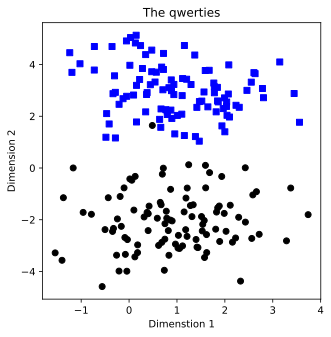

In [3]:
# create data

nPerCLuster = 100
blur = 1

A = [1,3]
B = [1,-2]

a = [A[0]+ np.random.randn(nPerCLuster)*blur,A[1]+ np.random.randn(nPerCLuster)*blur]
b = [B[0]+ np.random.randn(nPerCLuster)*blur,B[1]+ np.random.randn(nPerCLuster)*blur]

# true label
labels_np = np.vstack((np.zeros((nPerCLuster,1)),np.ones((nPerCLuster,1))))
 # concatinate into a matrix
data_np = np.hstack((a,b)).T

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# plot the data
fig= plt.subplots(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties")
plt.xlabel("Dimenstion 1")
plt.ylabel("Dimension 2")
plt.show()

In [4]:
print(data.shape)

torch.Size([200, 2])


In [5]:
def buildModel(learningRate):
    
    # model architecture
    ANNcls = nn.Sequential(
        nn.Linear(2,16),
        nn.ReLU(),
        nn.Linear(16,1),
        nn.ReLU(),
        nn.Linear(1,1),
        nn.Sigmoid()
    )
     # better to use BCEWithLogitsLoss
    lossFn = nn.BCELoss()
    
    # optimizer
    optimizer = torch.optim.SGD(ANNcls.parameters(), lr=learningRate)
    
    return ANNcls,lossFn,optimizer

In [11]:
# fixed parameters
num_epoches = 1000

def trainModel(ANNcls,lossFn,optimizer):
    
    losses = torch.zeros(num_epoches)
    
    for epochIdx in range(num_epoches):
        
        y_hat = ANNcls.forward(data)
        
        loss = lossFn(y_hat,labels)
        losses[epochIdx] = loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # final forward pass
    predictions = ANNcls.forward(data)
    
    totalAcc = 100 * torch.mean(((predictions > .5) == labels).float())
    
    return losses,predictions,totalAcc
        

## Testing new code

Final Acc:99.5


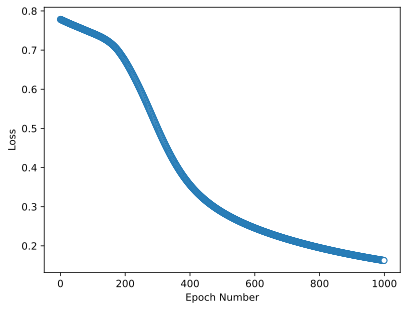

In [13]:
ANNcls,lossFn,optimizer = buildModel(0.01)

losses,predictions,totalAcc = trainModel(ANNcls,lossFn,optimizer)

print("Final Acc:{}".format(totalAcc))


plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [14]:
learningRates = np.linspace(0.001,0.1,50)

# init
accByLr = []
allLosses = torch.zeros((len(learningRates),num_epoches))


# the loop
for i,lr in enumerate(learningRates):
    
    # create and run the model
    ANNcls,lossFn,optimizer = buildModel(lr)
    losses,predictions,totalAcc = trainModel(ANNcls,lossFn,optimizer)
    
    accByLr.append(totalAcc)
    allLosses[i,:] = losses.detach()

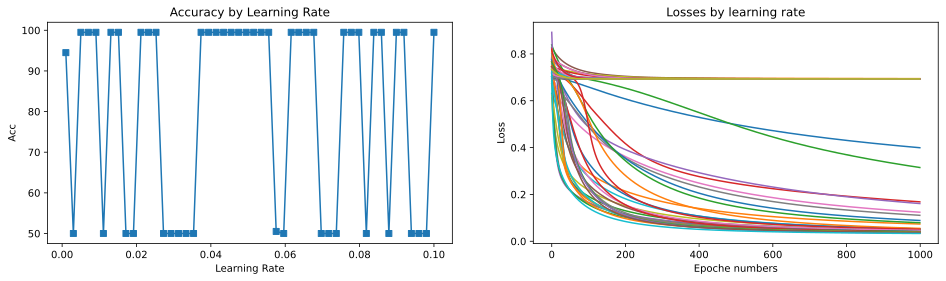

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,4))

ax[0].plot(learningRates,accByLr,'s-')
ax[0].set_xlabel("Learning Rate")
ax[0].set_ylabel("Acc")
ax[0].set_title("Accuracy by Learning Rate")

ax[1].plot(allLosses.T)
ax[1].set_title("Losses by learning rate")
ax[1].set_xlabel("Epoche numbers")
ax[1].set_ylabel("Loss")
plt.show()

In [16]:
sum(torch.tensor(accByLr) > 70)/len(accByLr)

tensor(0.6200)

In [17]:
predLabels = predictions>.5

# find errors
misCls = np.where(predLabels != labels)[0]

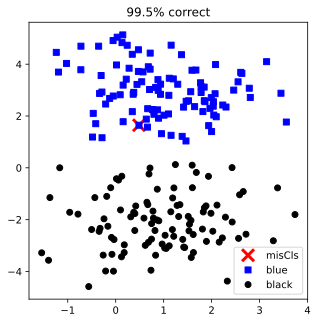

In [18]:
# plot the labeled data

fig = plt.figure(figsize=(5,5))
plt.plot(data[misCls,0],data[misCls,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predLabels)[0],0],data[np.where(~predLabels)[0],1],'bs')
plt.plot(data[np.where(predLabels)[0],0],data[np.where(predLabels)[0],1],'ko')

plt.legend(['misCls','blue','black'])
plt.title(f"{totalAcc}% correct")
plt.show()